# Yeast G-Protein Cycle

In [1]:
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy

In [2]:
sys.path.append('../..')
import spatialpy

In [3]:
class PheromoneGradient(spatialpy.DataFunction):
    def __init__(self, a=0.0, b=1.0, L_min=0, L_max=4, MOLAR=1.0):
        """ 1D domain from a to b. """
        spatialpy.DataFunction.__init__(self, name="PheromoneGradient")
        self.a = a
        self.b = b
        self.L_min = L_min
        self.L_max = L_max
        self.MOLAR = MOLAR

    def expression(self):
        return f"({(self.L_max - self.L_min) * 0.5} * (1 + cos(0.5 * me->x[0])) + {self.L_min}) * {self.MOLAR}"
    
    def map(self, x): #for visualization
        return ((self.L_max - self.L_min) * 0.5 * (1 + math.cos(0.5 * x[0])) + self.L_min) * self.MOLAR

In [4]:
class G_protein_cycle_1D(spatialpy.Model):

    def __init__(self,model_name="G_protein_cycle_1D"):
        spatialpy.Model.__init__(self,model_name)

        # Species
        # R RL G Ga Gbg Gd
        R = spatialpy.Species(name="R", diffusion_coefficient=0.01)
        RL = spatialpy.Species(name="RL", diffusion_coefficient=0.01)
        G = spatialpy.Species(name="G", diffusion_coefficient=0.01)
        Ga = spatialpy.Species(name="Ga", diffusion_coefficient=0.01)
        Gbg = spatialpy.Species(name="Gbg",diffusion_coefficient=0.01)
        Gd = spatialpy.Species(name="Gd", diffusion_coefficient=0.01)
        self.add_species([R, RL, G, Ga, Gbg, Gd])
    
        L = 4 * 3.14159
        NUM_VOXELS = 200
        MOLAR=6.02e-01 * ((L / NUM_VOXELS)**3)
        self.domain = spatialpy.Domain.create_2D_domain(
            ny=1, nx=NUM_VOXELS, xlim=(-2 * numpy.pi, 2 * numpy.pi), ylim=(0, 1))
        
        SA = spatialpy.Parameter(name="SA", expression=201.056)
        V = spatialpy.Parameter(name="V", expression=33.5)
        k_RL = spatialpy.Parameter(name="k_RL", expression=2e-03 / MOLAR)
        k_RLm = spatialpy.Parameter(name="k_RLm", expression=1e-02)
        k_Rs = spatialpy.Parameter(name="k_Rs", expression="4.0 / SA")
        k_Rd0 = spatialpy.Parameter(name="k_Rd0", expression=4e-04)
        k_Rd1 = spatialpy.Parameter(name="k_Rd1", expression=4e-04)
        k_G1 = spatialpy.Parameter(name="k_G1", expression="1.0 * SA")
        k_Ga = spatialpy.Parameter(name="k_Ga", expression="1e-06 * SA")
        k_Gd = spatialpy.Parameter(name="k_Gd", expression=0.1)
        self.add_parameter([SA, V, k_RL, k_RLm, k_Rs, k_Rd0, k_Rd1, k_G1, k_Ga, k_Gd]) 

        # Add Data Function to model the mating pheromone gradient.
        self.add_data_function(PheromoneGradient(a=-2 * 3.14159, b=2 * 3.14159, MOLAR=MOLAR))

        # Reactions
        R0 = spatialpy.Reaction(name="R0", reactants={}, products={R:1}, rate=k_Rs)
        R1 = spatialpy.Reaction(name="R1", reactants={R:1}, products={}, rate=k_Rd0)
        R2 = spatialpy.Reaction(name="R2", reactants={R:1}, products={RL:1}, 
                                propensity_function="k_RL * R * PheromoneGradient / vol")
        R3 = spatialpy.Reaction(name="R3", reactants={RL:1}, products={R:1}, rate=k_RLm)
        R4 = spatialpy.Reaction(name="R4", reactants={RL:1}, products={}, rate=k_RLm)
        R5 = spatialpy.Reaction(name="R5", reactants={G:1}, products={Ga:1, Gbg:1}, 
                                propensity_function="k_Ga * RL * G / vol")
        R6 = spatialpy.Reaction(name="R6", reactants={Ga:1}, products={Gd:1}, rate=k_Ga)
        R7 = spatialpy.Reaction(name="R7", reactants={Gd:1, Gbg:1}, products={G:1}, rate=k_G1)
        self.add_reaction([R0, R1, R2, R3, R4, R5, R6, R7])
        
        # Distribute molecules randomly over the mesh according to their initial values
        self.add_initial_condition(spatialpy.ScatterInitialCondition(R, 10000))
        self.add_initial_condition(spatialpy.ScatterInitialCondition(G, 10000))

        self.timespan(range(11))

### Generate the model and run the simulation

In [5]:
model = G_protein_cycle_1D()

In [6]:
%time result = model.run()

CPU times: user 31 ms, sys: 6.71 ms, total: 37.7 ms
Wall time: 17.8 s


### Output graphs of the spatial profiles of the species in the G-Protein cycle

In [7]:
def plot(sname):
    x_vals = model.domain.coordinates()[:,0]
    
    tspan_len = len(model.tspan)
    num_rows = math.ceil(tspan_len/2)
    fig, axs = plt.subplots(num_rows, 2, figsize=[15, 6 * num_rows])
    if tspan_len%2 != 0:
        fig.delaxes(axs[num_rows - 1, 1])
    
    for n, t in enumerate(model.tspan):
        S = result.get_species(sname, timepoints=n)
        axs[int(n/2), n%2].plot(x_vals, S)
        axs[int(n/2), n%2].set_title(f'{t}   t={sname}')

In [8]:
def plot_timepoint(sname, n):
    x_vals = model.domain.coordinates()[:,0]
    S = result.get_species(sname, timepoints=n)
    
    plt.plot(x_vals, S)
    plt.title(f'{n}   t={sname}')

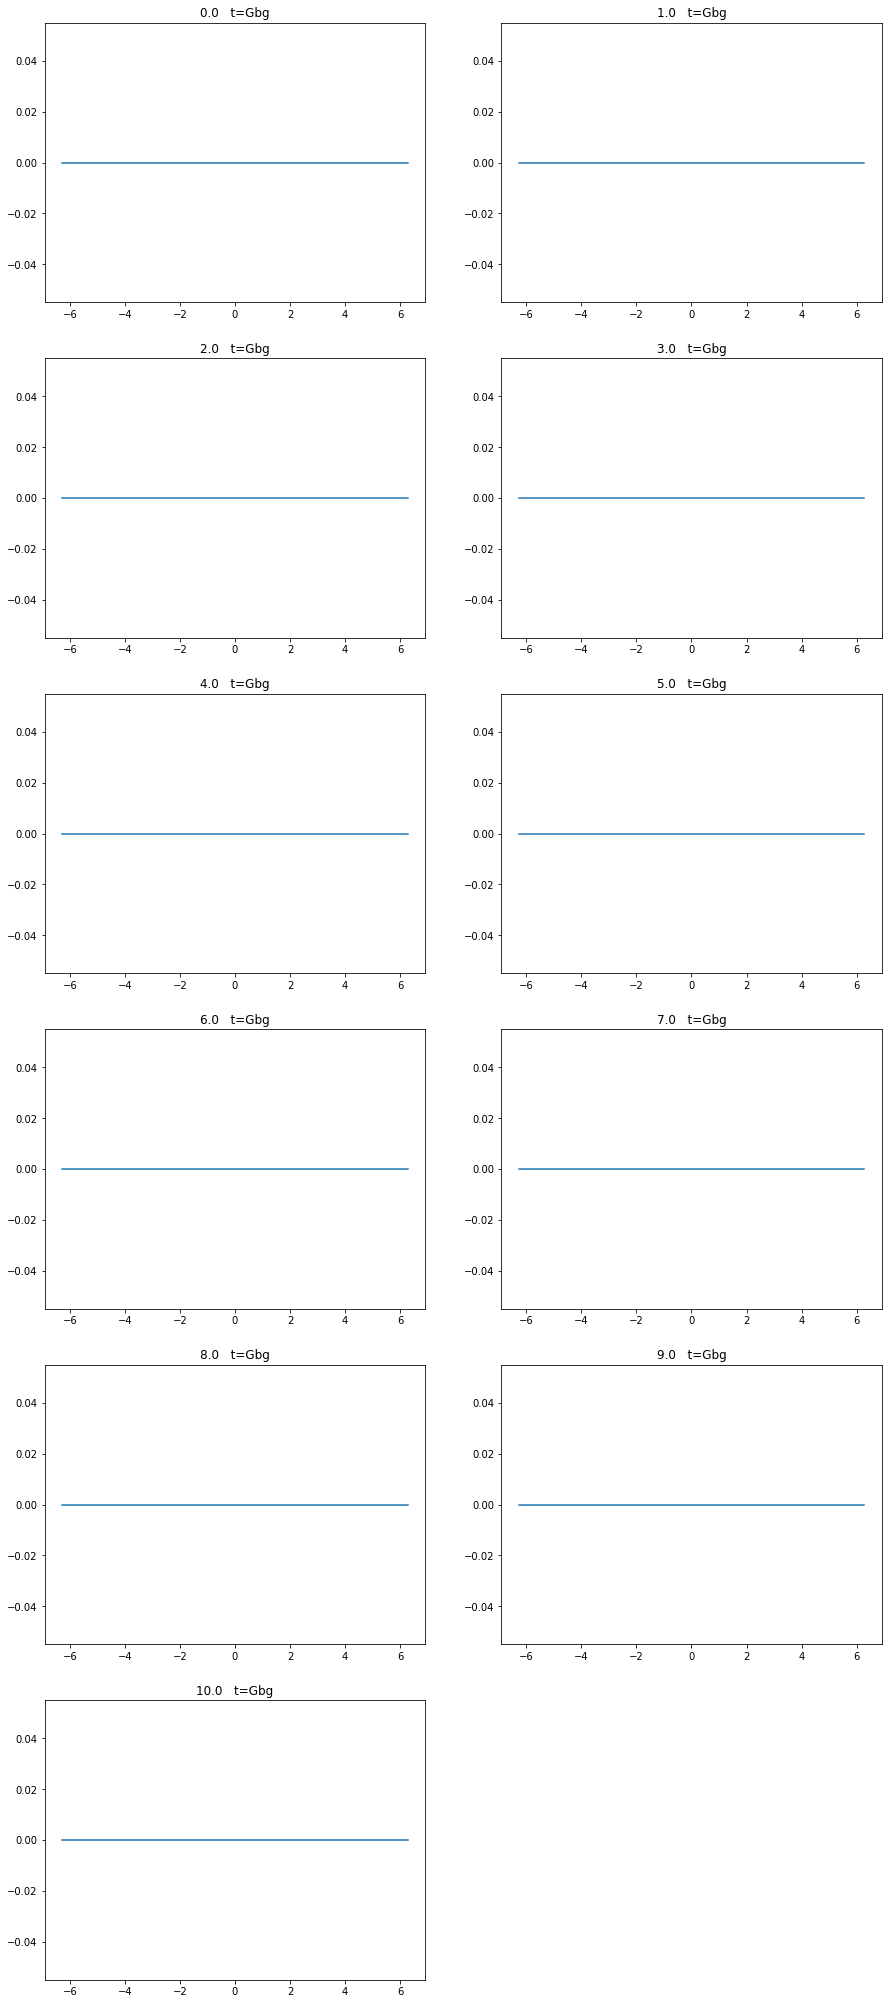

In [9]:
plot("Gbg")

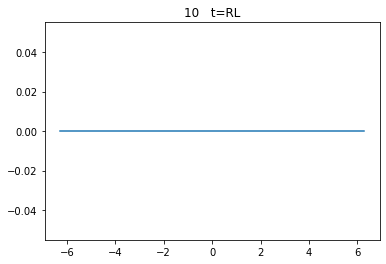

In [10]:
plot_timepoint("RL", 10)

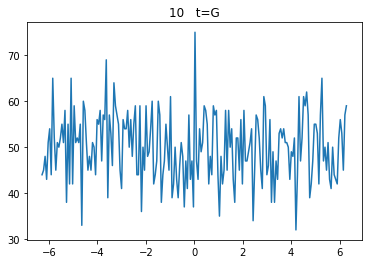

In [11]:
plot_timepoint("G", 10)

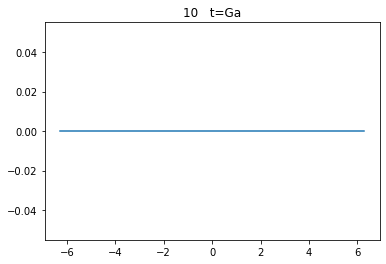

In [12]:
plot_timepoint("Ga", 10)

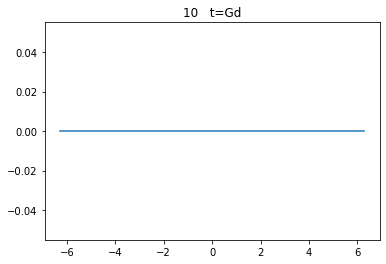

In [13]:
plot_timepoint("Gd", 10)

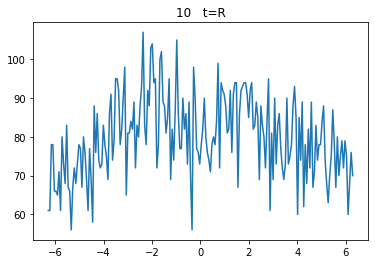

In [14]:
plot_timepoint("R", 10)

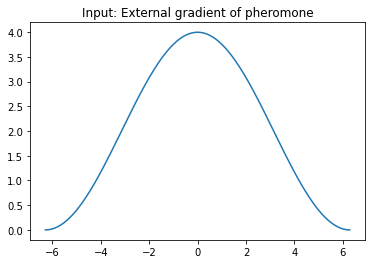

In [15]:
L = 4*3.14159
NUM_VOXEL = 200
MOLAR=6.02e-01*((L/NUM_VOXEL)**3)
x_vals = model.domain.coordinates()[:, 0]
pg = PheromoneGradient()
gradient = [pg.map([x]) for x in x_vals]
plt.plot(x_vals, gradient)
_ = plt.title('Input: External gradient of pheromone')